In [15]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

import cpn_model
import config
import michaels_load
import mRNN
import stim_model
import utils


OBSERVER_TYPE = "gaussian"
LESION_PCT = 0.75
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_MODULE_ID = "F5"
OBS_OUT_DIM = 20
NUM_STIM_CHANNELS = 60
BATCH_SIZE = 75

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type="connection",
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=35,
                                              obs_out_dim=OBS_OUT_DIM)

CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Set up the Michaels mRNN

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path())
mike.set_lesion(lesion_instance)
mike.reset()

In [17]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(), with_label=True)

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Loader produces lists of len 2:
#  (input of batch, output of batch); which is:
#  (shape(<=batch_size, time, 21), shape(<=batch_size, time, 50))

torch.Size([341, 1])


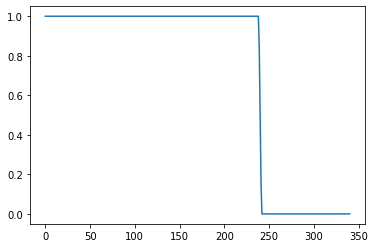

In [120]:
# Hold signal is in the last position
plt.plot(dataset[0][0][:, -1:].detach().numpy())
print(dataset[0][0][:, -1:].shape)
plt.show()

In [44]:
# Question 1: can we find the hold signal?

loss = torch.nn.MSELoss()
model = utils.LSTMModel(OBS_OUT_DIM * 2, 1, num_neurons=OBS_OUT_DIM)
opt = AdamW(model.parameters(), lr=2e-3)
ll = 1

for param in mike.parameters():
    param.requires_grad=False
    
eidx = 0
while ll > 1e-3:
    for batch in loader:
        if ll < 0.1:
            for p in opt.param_groups:
                p['lr'] = 1e-4
        if ll < 0.02:
            for p in opt.param_groups:
                p['lr'] = 3e-5
                
        opt.zero_grad()
        
        din, trial_end, trial_len, dout, dlabel = batch
        steps = din.shape[1]
        batch_size = din.shape[0]
        
        dvis = din[:, :, :-1]
        dhold = din[:, :, -1:]
        
        mike.reset()
        model.reset()
        
        preds = torch.zeros(batch_size, steps, 1)
        for tidx in range(steps):
            mike_in = din[:, tidx, :].T
            mike(mike_in)
            
            obs = mike.observe(observer, drop_module_idx=1)
            new_obs = torch.cat(tuple([torch.tensor(o).float() for o in obs]),
                            axis=1)
            pred = model(new_obs)
            preds[:, tidx, :] = pred[:, :]
        
        la = loss(preds, dhold)
        la.backward()
        opt.step()
        ll = la.item()
        print(eidx, ll)
        
        eidx += 1

        
        break
    break
        
        
# Yes. That works

0 0.017514115199446678


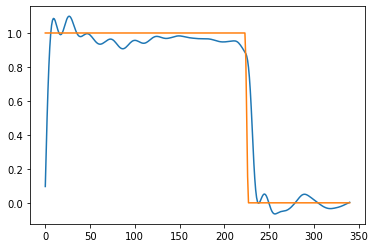

In [45]:
plt.plot(preds[1, :, 0].detach().numpy())
plt.plot(dhold[1, :, 0].detach().numpy())
plt.show()

In [38]:
# Question 2: can we separate the classes?

loss = nn.CrossEntropyLoss()
#model = utils.LSTMModel(2*OBS_OUT_DIM, 7, num_neurons=3*OBS_OUT_DIM)
#opt = AdamW(model.parameters(), lr=1e-3)#, weight_decay=0.04)
ll = 1

for param in mike.parameters():
    param.requires_grad=False
    
eidx = 0
losses = []
while ll > 0.5:
    for batch in loader:
        if ll >= 1.6:
            for p in opt.param_groups:
                p['lr'] = 1e-3
        elif ll < 1.6:
            for p in opt.param_groups:
                p['lr'] = 1e-5
        elif ll < 1.3:
            for p in opt.param_groups:
                p['lr'] = 5e-6
        elif ll < 1:
            for p in opt.param_groups:
                p['lr'] = 3e-6
        
        din, trial_end, trial_len, dout, dlabel = batch
        
        # Let's actually see if the early trial info is enough...
        steps = din.shape[1]
        #steps = 231
        batch_size = din.shape[0]
        
        opt.zero_grad() 
        mike.reset()
        model.reset()
        for tidx in range(steps):
            mike_in = din[:, tidx, :].T
            mike(mike_in)            
            
            obs = mike.observe(observer)
            new_obs = torch.cat(tuple([torch.tensor(o).float() for o in obs[1:]]),
                            axis=1)
            pred = model(new_obs)
                
        la = loss(pred, dlabel)
        
        correct = 0
        for x in range(batch_size):
            m = torch.argmax(pred[x, :])
            if m == dlabel[x]:
                correct += 1
        print(eidx, f"{correct}/{batch_size}", la.item())
        
        ll = la.item()
        if len(losses) > 5 and ll > (1.15 * sum(losses[-5:]) / 5) and losses[-1] < 1.75:
            print("pass")
        else:
            la.backward()
            opt.step()
            losses.append(ll)
        
        eidx += 1





0 12/75 1.9422048330307007
1 14/75 1.9336812496185303
2 7/75 1.9386869668960571
3 9/75 1.942474126815796
4 11/75 1.9428892135620117
5 11/75 1.942745566368103
6 8/52 1.937691569328308
7 11/75 1.9320672750473022
8 10/75 1.936293363571167
9 8/75 1.9401671886444092
10 14/75 1.935213565826416
11 12/75 1.9375154972076416
12 11/75 1.9300479888916016
13 6/52 1.9387662410736084
14 10/75 1.9290506839752197
15 13/75 1.9229642152786255
16 7/75 1.9389748573303223
17 8/75 1.9352431297302246
18 15/75 1.9164373874664307
19 8/75 1.930931806564331
20 11/52 1.9073783159255981
21 8/75 1.9186723232269287
22 11/75 1.91285240650177
23 10/75 1.9102944135665894
24 5/75 1.9327901601791382
25 13/75 1.8812068700790405
26 13/75 1.8611122369766235
27 14/52 1.8301810026168823
28 9/75 1.8718267679214478
29 19/75 1.835191249847412
30 26/75 1.8357958793640137
31 25/75 1.7753708362579346
32 23/75 1.7729105949401855
33 23/75 1.741079330444336
34 12/52 1.801261067390442
35 21/75 1.8256319761276245
36 11/75 1.9468685388565

290 39/75 1.4493423700332642
291 36/75 1.4150781631469727
292 38/75 1.5239876508712769
293 25/52 1.4273146390914917
294 29/75 1.5342390537261963
295 42/75 1.3732998371124268
296 40/75 1.4370640516281128
297 41/75 1.3683558702468872
298 30/75 1.508111834526062
299 42/75 1.4040353298187256
300 33/52 1.3080260753631592
301 28/75 1.4859586954116821
302 41/75 1.3968188762664795
303 41/75 1.4520854949951172
304 42/75 1.394364356994629
305 41/75 1.381289005279541
306 39/75 1.3955650329589844
307 26/52 1.457140564918518
308 37/75 1.410742163658142
309 48/75 1.3861539363861084
310 35/75 1.4291365146636963
311 34/75 1.428693175315857
312 40/75 1.4137921333312988
313 40/75 1.3677045106887817
314 22/52 1.5350788831710815
315 28/75 1.4907937049865723
316 41/75 1.366101622581482
317 45/75 1.3760398626327515
318 32/75 1.4185080528259277
319 40/75 1.3985419273376465
320 40/75 1.4462062120437622
321 29/52 1.426051378250122
322 46/75 1.3105307817459106
323 38/75 1.4183791875839233
324 40/75 1.4153165817

576 34/75 1.3051649332046509
577 40/75 1.3056602478027344
578 41/75 1.2530512809753418
579 36/75 1.4088709354400635
580 29/52 1.2693705558776855
581 40/75 1.294947862625122
582 38/75 1.3082056045532227
583 37/75 1.308165431022644
584 41/75 1.2597368955612183
585 36/75 1.3664883375167847
586 37/75 1.362216830253601
587 24/52 1.333864688873291
588 36/75 1.3439284563064575
589 37/75 1.328198790550232
590 39/75 1.2831951379776
591 40/75 1.3141194581985474
592 34/75 1.304445743560791
593 39/75 1.331771969795227
594 28/52 1.3130446672439575
595 39/75 1.2361245155334473
596 33/75 1.3324294090270996
597 42/75 1.340916395187378
598 38/75 1.3396893739700317
599 38/75 1.3428648710250854
600 41/75 1.2756171226501465
601 24/52 1.3523714542388916
602 39/75 1.3165535926818848
603 39/75 1.294390320777893
604 40/75 1.3225324153900146
605 41/75 1.2879780530929565
606 36/75 1.2943917512893677
607 36/75 1.3946359157562256
608 24/52 1.2765061855316162
609 38/75 1.3189367055892944
610 39/75 1.34306299686431

862 41/75 1.2688415050506592
863 43/75 1.1802499294281006
864 32/75 1.2640091180801392
865 38/75 1.2800168991088867
866 38/75 1.2434836626052856
867 27/52 1.273982286453247
868 37/75 1.265947699546814
869 34/75 1.3043036460876465
870 46/75 1.182113766670227
871 32/75 1.3087223768234253
872 42/75 1.2355562448501587
873 39/75 1.216377854347229
874 25/52 1.278525471687317
875 45/75 1.1888628005981445
876 32/75 1.3081789016723633
877 37/75 1.2578911781311035
878 39/75 1.2119622230529785
879 36/75 1.2901527881622314
880 37/75 1.2896960973739624
881 29/52 1.2202467918395996
882 41/75 1.2100841999053955
883 38/75 1.2229877710342407
884 27/75 1.4361374378204346
pass
885 37/75 1.2292799949645996
886 42/75 1.1767387390136719
887 44/75 1.2426693439483643
888 27/52 1.2516013383865356
889 38/75 1.3103644847869873
890 31/75 1.3030102252960205
891 39/75 1.2014877796173096
892 37/75 1.2868950366973877
893 41/75 1.25947904586792
894 39/75 1.2026523351669312
895 32/52 1.1741998195648193
896 38/75 1.2141

1143 35/75 1.2096096277236938
1144 40/75 1.1814192533493042
1145 41/75 1.2222042083740234
1146 39/75 1.263342022895813
1147 25/52 1.2323893308639526
1148 41/75 1.2239019870758057
1149 48/75 1.1240535974502563
1150 34/75 1.2907110452651978
1151 37/75 1.2184399366378784
1152 35/75 1.2527180910110474
1153 41/75 1.205527663230896
1154 28/52 1.1612963676452637
1155 36/75 1.2297255992889404
1156 43/75 1.2084566354751587
1157 38/75 1.2324978113174438
1158 43/75 1.113607406616211
1159 40/75 1.1978834867477417
1160 38/75 1.242084264755249
1161 25/52 1.2825076580047607
1162 36/75 1.2090452909469604
1163 36/75 1.245521903038025
1164 39/75 1.1892924308776855
1165 44/75 1.1918278932571411
1166 35/75 1.3151929378509521
1167 46/75 1.0745714902877808
1168 27/52 1.2705696821212769
1169 41/75 1.2487963438034058
1170 31/75 1.283679485321045
1171 40/75 1.162097692489624
1172 45/75 1.146345615386963
1173 38/75 1.1871733665466309
1174 41/75 1.261610507965088
1175 26/52 1.1707806587219238
1176 42/75 1.172301

1419 42/75 1.2237852811813354
1420 24/52 1.1818772554397583
1421 47/75 1.1436325311660767
1422 41/75 1.1447621583938599
1423 39/75 1.181077480316162
1424 46/75 1.1192518472671509
1425 37/75 1.1726680994033813
1426 34/75 1.272993803024292
1427 31/52 1.1910338401794434
1428 46/75 1.1159310340881348
1429 35/75 1.2186896800994873
1430 38/75 1.266217827796936
1431 39/75 1.1518665552139282
1432 45/75 1.1667708158493042
1433 44/75 1.1123299598693848
1434 25/52 1.1826300621032715
1435 45/75 1.149492859840393
1436 39/75 1.1842021942138672
1437 35/75 1.1596161127090454
1438 45/75 1.193611741065979
1439 38/75 1.2270737886428833
1440 41/75 1.1180109977722168
1441 29/52 1.1728018522262573
1442 46/75 1.097933292388916
1443 42/75 1.1448493003845215
1444 36/75 1.2397096157073975
1445 36/75 1.2296769618988037
1446 48/75 1.1184245347976685
1447 43/75 1.1463052034378052
1448 22/52 1.2431424856185913
1449 40/75 1.1908098459243774
1450 42/75 1.1744532585144043
1451 43/75 1.1822563409805298
1452 43/75 1.127

1695 38/75 1.1374869346618652
1696 37/75 1.1525928974151611
1697 44/75 1.1417056322097778
1698 42/75 1.1118369102478027
1699 45/75 1.1273438930511475
1700 30/52 1.202168345451355
1701 41/75 1.149010181427002
1702 35/75 1.1972334384918213
1703 46/75 1.1005940437316895
1704 47/75 1.0745011568069458
1705 41/75 1.184645652770996
1706 45/75 1.1167099475860596
1707 26/52 1.1444286108016968
1708 41/75 1.1388169527053833
1709 40/75 1.160049557685852
1710 47/75 1.1181963682174683
1711 46/75 1.1776481866836548
1712 41/75 1.0961549282073975
1713 38/75 1.1518954038619995
1714 28/52 1.107836127281189
1715 44/75 1.1290943622589111
1716 44/75 1.1481859683990479
1717 37/75 1.1434061527252197
1718 41/75 1.1558160781860352
1719 46/75 1.0630369186401367
1720 41/75 1.167504072189331
1721 27/52 1.154884934425354
1722 39/75 1.1666369438171387
1723 39/75 1.1715023517608643
1724 41/75 1.1529124975204468
1725 51/75 1.0837842226028442
1726 39/75 1.1104768514633179
1727 41/75 1.1062604188919067
1728 31/52 1.1666

1971 39/75 1.147494912147522
1972 46/75 1.0908446311950684
1973 30/52 1.072848916053772
1974 45/75 1.0960540771484375
1975 38/75 1.177860975265503
1976 38/75 1.1332107782363892
1977 39/75 1.1600704193115234
1978 51/75 0.9801856279373169
1979 45/75 1.0965447425842285
1980 28/52 1.108773112297058
1981 39/75 1.1205450296401978
1982 38/75 1.1631487607955933
1983 42/75 1.067486047744751
1984 40/75 1.133567452430725
1985 44/75 1.0723110437393188
1986 53/75 1.0754858255386353
1987 29/52 1.1176005601882935
1988 36/75 1.1299701929092407
1989 44/75 1.1585153341293335
1990 43/75 1.0647295713424683
1991 46/75 1.0400255918502808
1992 38/75 1.1695574522018433
1993 46/75 1.1060774326324463
1994 32/52 1.056837558746338
1995 43/75 1.0256352424621582
1996 41/75 1.152511715888977
1997 46/75 1.0901858806610107
1998 42/75 1.1056464910507202
1999 38/75 1.1706855297088623
2000 47/75 1.0615538358688354
2001 28/52 1.1418474912643433
2002 43/75 1.1397534608840942
2003 42/75 1.116343379020691
2004 42/75 1.075513

2247 37/75 1.1785731315612793
2248 44/75 1.099937081336975
2249 48/75 1.0213948488235474
2250 47/75 1.0441200733184814
2251 39/75 1.1651806831359863
2252 44/75 1.0238713026046753
2253 32/52 1.0511492490768433
2254 46/75 1.0691475868225098
2255 45/75 1.017307162284851
2256 38/75 1.11903715133667
2257 42/75 1.103000283241272
2258 45/75 1.1649423837661743
2259 41/75 1.0374335050582886
2260 33/52 1.0817205905914307
2261 48/75 1.0702433586120605
2262 39/75 1.1212329864501953
2263 41/75 1.0212546586990356
2264 38/75 1.0960581302642822
2265 48/75 1.044778823852539
2266 43/75 1.1506351232528687
2267 35/52 1.0869745016098022
2268 38/75 1.093051552772522
2269 40/75 1.1644721031188965
2270 44/75 1.0801030397415161
2271 45/75 1.0918290615081787
2272 44/75 1.1042156219482422
2273 44/75 1.0295344591140747
2274 37/52 0.9940754771232605
2275 42/75 1.1123870611190796
2276 42/75 1.097177267074585
2277 45/75 1.0478036403656006
2278 49/75 1.0535482168197632
2279 47/75 1.038745403289795
2280 43/75 1.097019

2522 37/75 1.0747592449188232
2523 41/75 1.0602577924728394
2524 41/75 1.1027061939239502
2525 41/75 1.0650256872177124
2526 32/52 1.0785763263702393
2527 43/75 1.0621181726455688
2528 40/75 1.1037628650665283
2529 44/75 1.080743670463562
2530 47/75 1.0284055471420288
2531 44/75 1.0610425472259521
2532 45/75 1.040030837059021
2533 29/52 1.0993821620941162
2534 50/75 1.05689537525177
2535 39/75 1.1234246492385864
2536 46/75 0.9713559746742249
2537 42/75 1.104112148284912
2538 45/75 1.107731580734253
2539 39/75 1.0778958797454834
2540 32/52 1.0008673667907715
2541 45/75 0.9941375851631165
2542 47/75 1.1179285049438477
2543 52/75 1.009642481803894
2544 43/75 1.0619378089904785
2545 39/75 1.1046444177627563
2546 35/75 1.1443110704421997
2547 32/52 1.0087554454803467
2548 47/75 1.0264793634414673
2549 38/75 1.1023427248001099
2550 49/75 1.0233111381530762
2551 42/75 1.1199779510498047
2552 46/75 1.0471923351287842
2553 38/75 1.1503545045852661
2554 34/52 0.9513156414031982
2555 39/75 1.0891

2798 47/75 0.9920081496238708
2799 31/52 1.0979276895523071
2800 45/75 1.0530295372009277
2801 41/75 1.0702649354934692
2802 44/75 1.0708253383636475
2803 42/75 1.1048179864883423
2804 46/75 1.0215414762496948
2805 51/75 0.989276647567749
2806 29/52 1.0147385597229004
2807 44/75 1.0461690425872803
2808 48/75 1.0526306629180908
2809 44/75 1.0350884199142456
2810 42/75 1.0396751165390015
2811 45/75 1.04872465133667
2812 46/75 1.0490154027938843
2813 30/52 1.080687165260315
2814 46/75 1.0702649354934692
2815 45/75 1.0108873844146729
2816 51/75 0.9780508279800415
2817 45/75 1.007649302482605
2818 38/75 1.130942463874817
2819 43/75 1.0438646078109741
2820 29/52 1.1342298984527588
2821 46/75 1.0068931579589844
2822 41/75 1.0736836194992065
2823 51/75 1.0374983549118042
2824 41/75 1.0838053226470947
2825 42/75 1.0564824342727661
2826 41/75 1.2204300165176392
pass
2827 24/52 1.1317769289016724
2828 41/75 1.0938286781311035
2829 33/75 1.21233332157135
2830 45/75 1.0735608339309692
2831 44/75 1.

3073 46/75 1.0419443845748901
3074 50/75 0.9833051562309265
3075 44/75 1.0348987579345703
3076 42/75 1.0971053838729858
3077 41/75 1.0479694604873657
3078 42/75 1.07471764087677
3079 31/52 1.0050160884857178
3080 40/75 1.0554925203323364
3081 42/75 1.1013514995574951
3082 42/75 1.0231839418411255
3083 52/75 0.9350519776344299
3084 50/75 1.0194859504699707
3085 46/75 1.0452052354812622
3086 24/52 1.1546186208724976
3087 41/75 1.054056167602539
3088 46/75 0.950789213180542
3089 48/75 1.0349359512329102
3090 48/75 1.0647261142730713
3091 43/75 1.100396990776062
3092 41/75 1.0776238441467285
3093 29/52 1.0172346830368042
3094 45/75 1.027832269668579
3095 45/75 1.0777796506881714
3096 47/75 0.9962529540061951
3097 54/75 1.005318522453308
3098 38/75 1.1140007972717285
3099 43/75 1.0507365465164185
3100 25/52 1.0172574520111084
3101 42/75 1.0495232343673706
3102 48/75 1.033570647239685
3103 45/75 0.9802277684211731
3104 41/75 1.0712233781814575
3105 47/75 0.9860819578170776
3106 43/75 1.05903

3349 42/75 1.0265287160873413
3350 52/75 0.9675138592720032
3351 48/75 1.0194811820983887
3352 35/52 0.9410723447799683
3353 45/75 0.999866247177124
3354 39/75 1.111371636390686
3355 50/75 0.93267422914505
3356 47/75 1.0226033926010132
3357 46/75 0.9865125417709351
3358 43/75 1.1426414251327515
3359 33/52 1.0151612758636475
3360 47/75 1.0202364921569824
3361 48/75 1.0049364566802979
3362 40/75 1.1007589101791382
3363 51/75 0.9342185258865356
3364 51/75 1.0402988195419312
3365 38/75 1.0976059436798096
3366 29/52 1.0094135999679565
3367 46/75 1.0237572193145752
3368 43/75 1.0706454515457153
3369 41/75 1.0354814529418945
3370 48/75 1.005048394203186
3371 48/75 1.0265611410140991
3372 48/75 1.0318433046340942
3373 30/52 1.0138921737670898
3374 51/75 0.9452031254768372
3375 43/75 1.1331194639205933
3376 46/75 1.0003743171691895
3377 51/75 0.9993888139724731
3378 42/75 1.032995343208313
3379 40/75 1.0304315090179443
3380 31/52 1.0861117839813232
3381 43/75 1.086892008781433
3382 47/75 1.0862

3624 40/75 1.075498342514038
3625 28/52 1.0554172992706299
3626 53/75 0.9948205351829529
3627 47/75 0.973951518535614
3628 39/75 1.0818933248519897
3629 44/75 1.072015404701233
3630 48/75 1.0120351314544678
3631 45/75 0.996546745300293
3632 28/52 1.0189061164855957
3633 50/75 0.9691634178161621
3634 52/75 0.9366650581359863
3635 46/75 1.008867859840393
3636 46/75 1.0738940238952637
3637 44/75 1.0518178939819336
3638 35/75 1.1104516983032227
3639 30/52 0.9884204268455505
3640 44/75 1.020196795463562
3641 49/75 1.0242124795913696
3642 46/75 0.9912258982658386
3643 44/75 1.0181612968444824
3644 46/75 1.0732877254486084
3645 52/75 0.9643104076385498
3646 23/52 1.0720179080963135
3647 48/75 1.0180187225341797
3648 36/75 1.088761568069458
3649 50/75 1.0283734798431396
3650 46/75 1.0344626903533936
3651 48/75 0.9825720191001892
3652 39/75 1.04353928565979
3653 37/52 0.9193820357322693
3654 49/75 1.0104001760482788
3655 43/75 1.0965194702148438
3656 44/75 1.0712002515792847
3657 47/75 1.049479

3899 48/75 1.0195465087890625
3900 47/75 1.0253807306289673
3901 49/75 0.9868660569190979
3902 41/75 1.0373746156692505
3903 45/75 0.9945393800735474
3904 48/75 0.996373176574707
3905 26/52 1.0343940258026123
3906 36/75 1.1042048931121826
3907 48/75 0.9807661175727844
3908 51/75 0.985519289970398
3909 46/75 0.9938037991523743
3910 47/75 1.0026675462722778
3911 44/75 1.0044424533843994
3912 32/52 1.0161871910095215
3913 46/75 1.0069832801818848
3914 47/75 0.9529561400413513
3915 47/75 1.0292599201202393
3916 42/75 0.9964869022369385
3917 48/75 1.0722472667694092
3918 47/75 1.0313410758972168
3919 27/52 0.9879021048545837
3920 40/75 1.0342057943344116
3921 52/75 1.0285218954086304
3922 45/75 0.9691235423088074
3923 46/75 1.0376380681991577
3924 47/75 0.9788278341293335
3925 41/75 1.063441514968872
3926 33/52 0.9533267617225647
3927 46/75 1.0166661739349365
3928 45/75 1.013907790184021
3929 51/75 0.9997912645339966
3930 47/75 0.9721476435661316
3931 45/75 1.006131649017334
3932 44/75 1.02

4174 46/75 0.9682515263557434
4175 41/75 0.9941067695617676
4176 51/75 0.9585865139961243
4177 46/75 1.027525782585144
4178 29/52 1.0151915550231934
4179 39/75 1.081303358078003
4180 47/75 1.0401723384857178
4181 41/75 1.0859488248825073
4182 56/75 0.8779056072235107
4183 46/75 0.9361438751220703
4184 43/75 1.045870065689087
4185 35/52 0.9343907237052917
4186 44/75 0.9913594722747803
4187 55/75 0.9272407293319702
4188 45/75 1.0265010595321655
4189 43/75 1.0959724187850952
4190 41/75 1.042955756187439
4191 44/75 0.962052583694458
4192 34/52 0.9633668065071106
4193 48/75 0.955004870891571
4194 43/75 1.0633043050765991
4195 48/75 0.9799486398696899
4196 45/75 0.9760342240333557
4197 48/75 1.0180548429489136
4198 49/75 1.0203460454940796
4199 26/52 1.0087326765060425
4200 42/75 1.0290863513946533
4201 43/75 0.9974765777587891
4202 50/75 1.014167070388794
4203 47/75 0.970235288143158
4204 46/75 0.9887112379074097
4205 46/75 1.0518594980239868
4206 33/52 0.9504514932632446
4207 39/75 1.07392

4449 48/75 0.9048057198524475
4450 42/75 1.0099122524261475
4451 26/52 1.0861183404922485
4452 42/75 0.9911609888076782
4453 54/75 0.9529459476470947
4454 42/75 1.0240232944488525
4455 44/75 1.0192863941192627
4456 46/75 0.9771029949188232
4457 47/75 1.0011729001998901
4458 34/52 0.9928349852561951
4459 44/75 0.954135000705719
4460 47/75 0.9655384421348572
4461 48/75 1.0166802406311035
4462 45/75 1.0466140508651733
4463 47/75 0.9918741583824158
4464 45/75 0.9956860542297363
4465 33/52 0.9842594861984253
4466 48/75 0.977246105670929
4467 41/75 0.9866577386856079
4468 45/75 1.0402586460113525
4469 47/75 1.0053130388259888
4470 46/75 0.9772843718528748
4471 47/75 0.9839884638786316
4472 35/52 0.9809268712997437
4473 48/75 0.9587360620498657
4474 52/75 0.9329735040664673
4475 46/75 1.0019028186798096
4476 49/75 0.9847655296325684
4477 37/75 1.055579662322998
4478 40/75 1.031838297843933
4479 37/52 0.987924337387085
4480 48/75 0.959303081035614
4481 43/75 0.9889562129974365
4482 49/75 0.984

4724 32/52 0.998912513256073
4725 42/75 1.0016413927078247
4726 46/75 1.000128984451294
4727 44/75 1.0354429483413696
4728 48/75 0.9834946990013123
4729 54/75 0.9258546233177185
4730 45/75 0.9942916035652161
4731 33/52 0.9402037858963013
4732 52/75 0.9490228295326233
4733 47/75 1.047351598739624
4734 42/75 0.9780222773551941
4735 49/75 0.9664410352706909
4736 43/75 1.0230319499969482
4737 45/75 0.9865835309028625
4738 34/52 0.9238284230232239
4739 51/75 0.8749081492424011
4740 47/75 0.9621796607971191
4741 51/75 0.9044949412345886
4742 47/75 1.0087668895721436
4743 40/75 1.042578935623169
4744 45/75 1.0819213390350342
4745 31/52 1.0385111570358276
4746 48/75 0.9698392748832703
4747 40/75 1.016207218170166
4748 47/75 0.9905551075935364
4749 54/75 1.008741855621338
4750 48/75 0.9666795134544373
4751 41/75 1.0294734239578247
4752 32/52 0.9089762568473816
4753 46/75 0.9300046563148499
4754 51/75 0.9981353878974915
4755 48/75 1.024057388305664
4756 44/75 0.9906010031700134
4757 42/75 0.9957

5000 51/75 0.9489649534225464
5001 46/75 1.0185335874557495
5002 48/75 0.9280039668083191
5003 49/75 0.9369813203811646
5004 34/52 0.9819409251213074
5005 46/75 0.949475884437561
5006 41/75 0.983549177646637
5007 49/75 0.925096333026886
5008 56/75 0.8998262286186218
5009 46/75 0.9987239837646484
5010 46/75 1.0658824443817139
5011 33/52 1.0182607173919678
5012 39/75 1.0636217594146729
5013 47/75 0.9229148626327515
5014 48/75 0.9739423394203186
5015 54/75 0.9198596477508545
5016 51/75 0.946811854839325
5017 45/75 0.986480176448822
5018 33/52 1.0282725095748901
5019 47/75 1.0384026765823364
5020 52/75 0.905327558517456
5021 48/75 0.8706827759742737
5022 49/75 0.9976208209991455
5023 44/75 1.067944049835205
5024 46/75 0.972318708896637
5025 31/52 0.9698893427848816
5026 51/75 0.9671092629432678
5027 39/75 1.092221975326538
5028 51/75 0.9376181960105896
5029 50/75 0.9381340742111206
5030 48/75 0.9820289015769958
5031 43/75 1.003515362739563
5032 35/52 0.8696746230125427
5033 45/75 1.0564190

5275 44/75 0.9711627960205078
5276 44/75 1.0153230428695679
5277 34/52 1.0237104892730713
5278 51/75 0.9950234889984131
5279 44/75 0.9858577251434326
5280 46/75 0.9626502394676208
5281 47/75 0.9766438007354736
5282 51/75 0.8881209492683411
5283 47/75 1.009247899055481
5284 36/52 0.9348325729370117
5285 49/75 0.9338222146034241
5286 50/75 0.9601635932922363
5287 44/75 1.0707545280456543
5288 45/75 0.9811666011810303
5289 49/75 0.9550703763961792
5290 52/75 0.9234828948974609
5291 33/52 0.9227911233901978
5292 35/75 1.0950050354003906
5293 50/75 0.9827436208724976
5294 51/75 0.9136037230491638
5295 51/75 0.9685354828834534
5296 50/75 0.9595898389816284
5297 52/75 0.938736081123352
5298 35/52 0.8730320334434509
5299 48/75 0.9226599931716919
5300 48/75 0.9689784646034241
5301 45/75 1.0521811246871948
5302 55/75 0.898482084274292
5303 50/75 1.0231739282608032
5304 48/75 0.9159131050109863
5305 31/52 0.9796274900436401
5306 43/75 1.028322458267212
5307 52/75 0.9287523627281189
5308 50/75 0.9

5549 50/75 0.9467104077339172
5550 37/52 0.9237905740737915
5551 53/75 0.9344116449356079
5552 52/75 0.9192633032798767
5553 48/75 0.9751463532447815
5554 48/75 0.934005856513977
5555 44/75 0.9776972532272339
5556 47/75 0.9461266994476318
5557 33/52 1.0350285768508911
5558 49/75 0.9767258763313293
5559 53/75 0.8941580057144165
5560 53/75 0.9174309372901917
5561 40/75 0.9978798627853394
5562 53/75 0.9409945607185364
5563 43/75 1.014670729637146
5564 33/52 0.9527633190155029
5565 47/75 0.9216729998588562
5566 51/75 0.9376760125160217
5567 50/75 0.9608913064002991
5568 54/75 0.9080583453178406
5569 40/75 0.9710990190505981
5570 48/75 1.0265742540359497
5571 35/52 0.9732669591903687
5572 50/75 0.8932902812957764
5573 46/75 0.9773680567741394
5574 53/75 0.9461315870285034
5575 46/75 0.9560645818710327
5576 49/75 0.9695953130722046
5577 49/75 0.984004020690918
5578 32/52 0.9704542756080627
5579 52/75 0.910500168800354
5580 48/75 0.9965235590934753
5581 56/75 0.8808056712150574
5582 44/75 0.9

5824 45/75 0.9920645952224731
5825 44/75 1.0126012563705444
5826 46/75 0.9952625632286072
5827 52/75 0.8900189995765686
5828 54/75 0.9201318621635437
5829 44/75 0.9581875801086426
5830 41/52 0.8243591785430908
5831 47/75 1.0212066173553467
5832 53/75 0.9046265482902527
5833 52/75 0.9510849118232727
5834 43/75 0.9777754545211792
5835 48/75 0.9531903862953186
5836 45/75 0.9441895484924316
5837 39/52 0.8448852896690369
5838 55/75 0.8997138738632202
5839 46/75 0.994032621383667
5840 41/75 0.9415392279624939
5841 51/75 0.9908421039581299
5842 51/75 0.9672957062721252
5843 45/75 0.9783365726470947
5844 37/52 0.8145879507064819
5845 51/75 0.9717329740524292
5846 49/75 1.0312076807022095
5847 57/75 0.8675087690353394
5848 42/75 0.9839577078819275
5849 46/75 0.9328573346138
5850 51/75 0.9070117473602295
5851 29/52 0.9260205030441284
5852 52/75 0.9280771017074585
5853 53/75 0.927281379699707
5854 52/75 0.8736868500709534
5855 46/75 1.025124192237854
5856 50/75 0.8793219923973083
5857 43/75 0.985

6099 47/75 0.9627527594566345
6100 54/75 0.8311583995819092
6101 48/75 0.9138513207435608
6102 50/75 0.938418447971344
6103 36/52 0.9769132137298584
6104 50/75 0.947842538356781
6105 46/75 0.9536887407302856
6106 53/75 0.9643071293830872
6107 51/75 0.8796839118003845
6108 48/75 0.9212405681610107
6109 54/75 0.9374836087226868
6110 30/52 0.9650264382362366
6111 52/75 0.8851696848869324
6112 38/75 1.0457168817520142
6113 53/75 0.9348013401031494
6114 56/75 0.9529005885124207
6115 51/75 0.9116684198379517
6116 57/75 0.8576585650444031
6117 26/52 0.9867519736289978
6118 49/75 0.9529958963394165
6119 46/75 0.9533349871635437
6120 52/75 0.8556711673736572
6121 48/75 1.0221583843231201
6122 53/75 0.9108015894889832
6123 53/75 0.8731129169464111
6124 32/52 1.0134185552597046
6125 50/75 0.9758341312408447
6126 46/75 0.958747148513794
6127 55/75 0.8889322876930237
6128 50/75 0.9813770651817322
6129 54/75 0.8652054667472839
6130 46/75 0.976715624332428
6131 32/52 0.8959226012229919
6132 53/75 0.9

6373 49/75 0.9818876385688782
6374 48/75 1.0459935665130615
pass
6375 43/75 0.9890260100364685
6376 37/52 0.8188432455062866
6377 49/75 0.911699652671814
6378 49/75 0.9608603715896606
6379 43/75 0.9873655438423157
6380 51/75 0.9333363771438599
6381 53/75 0.8520670533180237
6382 57/75 0.9091612696647644
6383 33/52 0.9461157917976379
6384 57/75 0.9276522994041443
6385 48/75 0.9176968336105347
6386 51/75 0.9510195851325989
6387 51/75 0.914191484451294
6388 48/75 0.9392881393432617
6389 52/75 0.8828290700912476
6390 30/52 0.9731149673461914
6391 44/75 1.0062732696533203
6392 50/75 0.8900644779205322
6393 54/75 0.8754330277442932
6394 49/75 0.9312340021133423
6395 48/75 0.8809905052185059
6396 50/75 0.9955126047134399
6397 40/52 0.9036042094230652
6398 54/75 0.8789032101631165
6399 56/75 0.8886995315551758
6400 50/75 0.9031140208244324
6401 52/75 0.9054223895072937
6402 41/75 0.9458603858947754
6403 48/75 1.0222386121749878
6404 34/52 0.9533976316452026
6405 51/75 0.9231595993041992
6406 49

6647 54/75 0.959301769733429
6648 47/75 0.9172881245613098
6649 41/52 0.8553022742271423
6650 58/75 0.9068816900253296
6651 47/75 0.9434042572975159
6652 50/75 0.8514111042022705
6653 49/75 0.9328254461288452
6654 54/75 0.8933925628662109
6655 52/75 0.920784592628479
6656 31/52 1.0007892847061157
6657 57/75 0.902933657169342
6658 42/75 0.9192716479301453
6659 44/75 0.9787869453430176
6660 53/75 0.9551692605018616
6661 52/75 0.8789310455322266
6662 51/75 0.8871774077415466
6663 39/52 0.8946532011032104
6664 52/75 0.9303904175758362
6665 50/75 0.913943350315094
6666 49/75 0.9277553558349609
6667 50/75 0.9328803420066833
6668 57/75 0.8445695042610168
6669 48/75 0.9528546929359436
6670 35/52 0.9210553765296936
6671 48/75 1.0104081630706787
6672 51/75 0.8664214015007019
6673 53/75 0.9158519506454468
6674 49/75 0.982040524482727
6675 53/75 0.8428846597671509
6676 57/75 0.8377494812011719
6677 32/52 0.9856379628181458
6678 51/75 0.8492445945739746
6679 55/75 0.9558210372924805
6680 49/75 0.95

6921 58/75 0.8334671258926392
6922 31/52 0.9384580850601196
6923 44/75 0.9500235915184021
6924 54/75 0.8904335498809814
6925 51/75 0.8829442262649536
6926 53/75 0.9296192526817322
6927 51/75 0.898419201374054
6928 58/75 0.8628067970275879
6929 33/52 0.9539488554000854
6930 56/75 0.8566129803657532
6931 48/75 0.9023872017860413
6932 52/75 0.9008980393409729
6933 50/75 0.9630825519561768
6934 50/75 0.9115681052207947
6935 52/75 0.8908669948577881
6936 35/52 0.9340897798538208
6937 53/75 0.89748615026474
6938 54/75 0.8618866205215454
6939 47/75 0.9288744926452637
6940 47/75 0.9554164409637451
6941 55/75 0.8871411085128784
6942 54/75 0.9120189547538757
6943 33/52 0.9083222150802612
6944 52/75 0.9145011305809021
6945 48/75 0.9149325489997864
6946 57/75 0.8459625244140625
6947 43/75 1.0074529647827148
6948 53/75 0.8598638772964478
6949 51/75 0.932492196559906
6950 40/52 0.8572711944580078
6951 47/75 1.0121736526489258
6952 45/75 1.0036805868148804
6953 50/75 0.8810080885887146
6954 56/75 0.8

7195 35/52 0.8220211863517761
7196 49/75 0.9083212018013
7197 50/75 0.8439765572547913
7198 52/75 0.8861196041107178
7199 45/75 0.984332263469696
7200 50/75 0.9047368168830872
7201 53/75 0.8900938034057617
7202 36/52 0.9534175395965576
7203 54/75 0.8759496212005615
7204 51/75 0.9274390935897827
7205 53/75 0.9379308819770813
7206 54/75 0.8766232132911682
7207 51/75 0.9232494831085205
7208 38/75 0.9540970921516418
7209 35/52 0.8374776244163513
7210 51/75 0.9315418601036072
7211 44/75 0.9284780621528625
7212 51/75 0.8584350347518921
7213 54/75 0.894135057926178
7214 47/75 0.8985397219657898
7215 49/75 0.9339157342910767
7216 41/52 0.9058990478515625
7217 47/75 0.9393875002861023
7218 55/75 0.860629141330719
7219 50/75 0.8590276837348938
7220 48/75 0.9714499711990356
7221 56/75 0.9277777075767517
7222 43/75 0.9549315571784973
7223 37/52 0.8041476607322693
7224 49/75 0.8978569507598877
7225 55/75 0.9033610224723816
7226 51/75 0.8775094747543335
7227 53/75 0.9002376198768616
7228 45/75 0.956

7469 49/75 0.9457700848579407
7470 46/75 0.8984931707382202
7471 53/75 0.8916575908660889
7472 49/75 0.893288254737854
7473 50/75 0.9375298023223877
7474 51/75 0.8549761772155762
7475 33/52 0.8427628874778748
7476 58/75 0.8541684150695801
7477 46/75 0.9543424248695374
7478 44/75 0.8801741600036621
7479 49/75 0.8973063230514526
7480 50/75 0.9209427833557129
7481 46/75 0.9214182496070862
7482 38/52 0.831576406955719
7483 50/75 0.857986330986023
7484 48/75 0.9217813014984131
7485 47/75 0.915032148361206
7486 53/75 0.8606966137886047
7487 53/75 0.885330080986023
7488 49/75 0.923753023147583
7489 31/52 0.9202626943588257
7490 53/75 0.8279041647911072
7491 52/75 0.8223175406455994
7492 49/75 0.9233726263046265
7493 45/75 0.9632320404052734
7494 55/75 0.827017068862915
7495 38/75 1.0607954263687134
pass
7496 38/52 0.8322772979736328
7497 48/75 0.8946586847305298
7498 55/75 0.8402373790740967
7499 49/75 0.9205522537231445
7500 42/75 0.8587184548377991
7501 44/75 0.984057605266571
7502 51/75 0.

7743 49/75 0.9010832905769348
7744 44/75 0.9804773926734924
7745 51/75 0.9302425980567932
7746 50/75 0.7980577945709229
7747 48/75 0.9033276438713074
7748 32/52 0.8191925287246704
7749 49/75 0.8958005905151367
7750 49/75 0.8758121728897095
7751 52/75 0.8447555303573608
7752 42/75 0.9834344387054443
7753 51/75 0.830487072467804
7754 47/75 0.9067012667655945
7755 34/52 0.8764296770095825
7756 50/75 0.8738879561424255
7757 54/75 0.8464726805686951
7758 46/75 0.8895889520645142
7759 42/75 0.8904993534088135
7760 51/75 0.9402925372123718
7761 53/75 0.8397228717803955
7762 31/52 0.9573825001716614
7763 50/75 0.9262074828147888
7764 52/75 0.8953861594200134
7765 44/75 0.9181323051452637
7766 41/75 0.978531002998352
7767 50/75 0.7774818539619446
7768 55/75 0.8457195162773132
7769 34/52 0.8650544285774231
7770 46/75 0.8624598383903503
7771 49/75 0.8682019114494324
7772 47/75 0.8816233277320862
7773 54/75 0.8949407935142517
7774 54/75 0.9072780609130859
7775 46/75 0.8588081002235413
7776 28/52 0

8017 51/75 0.863389790058136
8018 46/75 0.8888603448867798
8019 53/75 0.8864535689353943
8020 51/75 0.8818640112876892
8021 29/52 0.9263906478881836
8022 49/75 0.8447394967079163
8023 46/75 0.8741673827171326
8024 45/75 0.9474520087242126
8025 49/75 0.8215216994285583
8026 45/75 0.9463949799537659
8027 54/75 0.824385404586792
8028 36/52 0.9011090397834778
8029 50/75 0.8690774440765381
8030 41/75 0.9652547240257263
8031 49/75 0.8060058951377869
8032 47/75 0.928755521774292
8033 51/75 0.8681243658065796
8034 51/75 0.8542593121528625
8035 35/52 0.8522460460662842
8036 53/75 0.8104745149612427
8037 52/75 0.8646515011787415
8038 49/75 0.9354734420776367
8039 41/75 0.9490355253219604
8040 45/75 0.8603912591934204
8041 46/75 0.9400641918182373
8042 39/52 0.7497031688690186
8043 49/75 0.8049483895301819
8044 44/75 0.9246231913566589
8045 51/75 0.9095503687858582
8046 44/75 0.8846578001976013
8047 54/75 0.821209192276001
8048 48/75 0.9392523169517517
8049 35/52 0.8571672439575195
8050 47/75 0.8

8290 51/75 0.8697512745857239
8291 52/75 0.8611542582511902
8292 50/75 0.8842708468437195
8293 48/75 0.8342599272727966
8294 27/52 1.0028263330459595
pass
8295 53/75 0.8527032136917114
8296 47/75 0.8763222098350525
8297 47/75 0.8805029392242432
8298 49/75 0.9070062041282654
8299 48/75 0.8134958744049072
8300 50/75 0.8619686961174011
8301 32/52 0.9073490500450134
8302 50/75 0.8533781170845032
8303 49/75 0.8031721711158752
8304 53/75 0.8815622925758362
8305 45/75 0.9592013359069824
8306 48/75 0.8726304173469543
8307 41/75 0.9172353148460388
8308 39/52 0.7697133421897888
8309 49/75 0.8591529130935669
8310 52/75 0.8276933431625366
8311 55/75 0.9067801833152771
8312 53/75 0.7740049958229065
8313 41/75 0.8689360618591309
8314 44/75 0.9361196160316467
8315 31/52 0.9340254068374634
8316 47/75 0.8560838103294373
8317 48/75 0.8821011185646057
8318 54/75 0.8337559103965759
8319 53/75 0.8505060076713562
8320 47/75 0.9145582318305969
8321 47/75 0.8523266911506653
8322 31/52 0.9033044576644897
8323 

8563 47/75 0.9029054045677185
8564 45/75 0.7993793487548828
8565 49/75 0.9418821930885315
8566 49/75 0.8461405634880066
8567 35/52 0.7579508423805237
8568 52/75 0.8042795062065125
8569 47/75 0.8682752251625061
8570 54/75 0.8068987131118774
8571 48/75 0.895094633102417
8572 52/75 0.8130748271942139
8573 39/75 0.9522494673728943
8574 36/52 0.8947731852531433
8575 44/75 0.8882163763046265
8576 47/75 0.9279085397720337
8577 55/75 0.8292138576507568
8578 50/75 0.8028953075408936
8579 52/75 0.8434472680091858
8580 50/75 0.86532062292099
8581 29/52 0.8675264120101929
8582 48/75 0.8351840972900391
8583 54/75 0.7934091091156006
8584 51/75 0.908460795879364
8585 47/75 0.9119486212730408
8586 53/75 0.7905485033988953
8587 47/75 0.9041045308113098
8588 29/52 0.8845894932746887
8589 45/75 0.8462050557136536
8590 51/75 0.8542887568473816
8591 48/75 0.8816035985946655
8592 45/75 0.9541518092155457
8593 54/75 0.7840394377708435
8594 49/75 0.9173600077629089
8595 36/52 0.7465581893920898
8596 55/75 0.7

8837 50/75 0.8713586330413818
8838 45/75 0.9417865872383118
pass
8839 51/75 0.8961944580078125
8840 33/52 0.8437880277633667
8841 50/75 0.8534778952598572
8842 55/75 0.7981755137443542
8843 48/75 0.8236791491508484
8844 50/75 0.8406569957733154
8845 52/75 0.8261047601699829
8846 44/75 0.9151014089584351
8847 35/52 0.9299029111862183
8848 57/75 0.7867924571037292
8849 47/75 0.9157759547233582
8850 47/75 0.8852734565734863
8851 54/75 0.848304033279419
8852 45/75 0.8759997487068176
8853 48/75 0.8451271653175354
8854 34/52 0.7872496247291565
8855 45/75 0.9058464765548706
8856 54/75 0.806100606918335
8857 56/75 0.7578012347221375
8858 43/75 0.9247273802757263
8859 54/75 0.7928323745727539
8860 44/75 0.9082644581794739
8861 38/52 0.8686301112174988
8862 55/75 0.7884324193000793
8863 46/75 0.9267266988754272
8864 55/75 0.784321129322052
8865 52/75 0.8090160489082336
8866 49/75 0.8605116009712219
8867 45/75 0.8829541206359863
8868 33/52 0.9291048645973206
8869 49/75 0.7520511150360107
8870 53/

9109 50/75 0.9210265874862671
9110 45/75 0.8743206858634949
9111 53/75 0.7620542049407959
9112 54/75 0.809162437915802
9113 38/52 0.7745304703712463
9114 52/75 0.7828335165977478
9115 49/75 0.8423653841018677
9116 53/75 0.8406853079795837
9117 48/75 0.8672371506690979
9118 49/75 0.8527235984802246
9119 53/75 0.8860729932785034
9120 30/52 0.8207880258560181
9121 50/75 0.7386181354522705
9122 53/75 0.8412123322486877
9123 49/75 0.8986708521842957
9124 54/75 0.8386144638061523
9125 50/75 0.8876749873161316
9126 46/75 0.8816515207290649
9127 34/52 0.7982088327407837
9128 50/75 0.8606993556022644
9129 55/75 0.8193325996398926
9130 50/75 0.8303418755531311
9131 47/75 0.8283063769340515
9132 51/75 0.8270871639251709
9133 48/75 0.902742326259613
9134 36/52 0.8187612295150757
9135 52/75 0.8376975059509277
9136 51/75 0.881027340888977
9137 52/75 0.8211234211921692
9138 48/75 0.8987330198287964
9139 50/75 0.7787494659423828
9140 48/75 0.8460491895675659
9141 34/52 0.826647162437439
9142 52/75 0.8

9383 51/75 0.8611525297164917
9384 56/75 0.7168335318565369
9385 46/75 0.898720920085907
9386 33/52 0.9266020059585571
9387 58/75 0.7241201996803284
9388 52/75 0.8751682639122009
9389 49/75 0.8181406259536743
9390 49/75 0.8160781264305115
9391 47/75 0.8877131342887878
9392 48/75 0.8744403123855591
9393 32/52 0.8420060873031616
9394 50/75 0.824286162853241
9395 54/75 0.8848758935928345
9396 50/75 0.7786310911178589
9397 54/75 0.8147192001342773
9398 50/75 0.7966470122337341
9399 48/75 0.8776383399963379
9400 33/52 0.8687109351158142
9401 56/75 0.7223602533340454
9402 47/75 0.8990665674209595
9403 51/75 0.8092496991157532
9404 58/75 0.7842328548431396
9405 46/75 0.9270484447479248
9406 50/75 0.7924988865852356
9407 31/52 0.9261030554771423
9408 51/75 0.8249647617340088
9409 53/75 0.7989559769630432
9410 47/75 0.822478711605072
9411 51/75 0.8533319234848022
9412 50/75 0.8604272603988647
9413 47/75 0.9097440838813782
9414 39/52 0.7301164865493774
9415 53/75 0.8116613626480103
9416 50/75 0.

9657 56/75 0.8158593773841858
9658 49/75 0.803810179233551
9659 34/52 0.8259626626968384
9660 49/75 0.8490509390830994
9661 54/75 0.7391977906227112
9662 49/75 0.9175170660018921
9663 47/75 0.8634292483329773
9664 49/75 0.8130789399147034
9665 54/75 0.7825724482536316
9666 38/52 0.8049420714378357
9667 52/75 0.8053754568099976
9668 46/75 0.9141818284988403
9669 50/75 0.8647384643554688
9670 52/75 0.812011182308197
9671 51/75 0.8210627436637878
9672 51/75 0.7461190819740295
9673 38/52 0.799590528011322
9674 48/75 0.9274594187736511
9675 49/75 0.8117486834526062
9676 52/75 0.8597109913825989
9677 52/75 0.8173339366912842
9678 53/75 0.7300273776054382
9679 53/75 0.7727341055870056
9680 33/52 0.8647451400756836
9681 46/75 0.8216768503189087
9682 50/75 0.769335150718689
9683 53/75 0.8217990398406982
9684 48/75 0.8942040801048279
9685 52/75 0.8740572333335876
9686 56/75 0.7636210918426514
9687 34/52 0.8231905698776245
9688 49/75 0.8603978753089905
9689 54/75 0.8163384795188904
9690 50/75 0.8

9931 53/75 0.7680402398109436
9932 40/52 0.735123336315155
9933 50/75 0.8767452239990234
9934 54/75 0.8166896104812622
9935 48/75 0.8859157562255859
9936 58/75 0.7138920426368713
9937 43/75 0.8165810108184814
9938 55/75 0.8014804124832153
9939 36/52 0.7971035838127136
9940 45/75 0.9091112017631531
9941 50/75 0.8316083550453186
9942 51/75 0.7958301901817322
9943 54/75 0.7821722626686096
9944 55/75 0.8135402202606201
9945 51/75 0.8295938968658447
9946 37/52 0.7254120707511902
9947 56/75 0.79233318567276
9948 53/75 0.8110952973365784
9949 49/75 0.7850205898284912
9950 45/75 0.8935226202011108
9951 54/75 0.7764236927032471
9952 49/75 0.8158811330795288
9953 37/52 0.8419113159179688
9954 56/75 0.7992796301841736
9955 52/75 0.812846839427948
9956 45/75 0.9046368598937988
9957 45/75 0.8129256963729858
9958 52/75 0.8100605010986328
9959 55/75 0.781025230884552
9960 37/52 0.779688835144043
9961 46/75 0.8693013787269592
9962 54/75 0.7549079656600952
9963 45/75 0.8743661642074585
9964 57/75 0.806

10197 55/75 0.7280181050300598
10198 36/52 0.8131316304206848
10199 48/75 0.7618772983551025
10200 52/75 0.8260499835014343
10201 52/75 0.824470043182373
10202 45/75 0.9194098711013794
pass
10203 54/75 0.7426363825798035
10204 53/75 0.7965864539146423
10205 39/52 0.7720240354537964
10206 54/75 0.7562569975852966
10207 43/75 0.8958613872528076
pass
10208 50/75 0.8043558597564697
10209 48/75 0.8655674457550049
10210 55/75 0.7954568862915039
10211 64/75 0.638828456401825
10212 29/52 0.9349243640899658
pass
10213 50/75 0.9135307669639587
pass
10214 44/75 0.8546952605247498
10215 54/75 0.7280642986297607
10216 53/75 0.7507548928260803
10217 51/75 0.8341854810714722
10218 53/75 0.7920935153961182
10219 39/52 0.7652110457420349
10220 48/75 0.8023737668991089
10221 55/75 0.8179405927658081
10222 51/75 0.7785762548446655
10223 54/75 0.7687955498695374
10224 57/75 0.7818725109100342
10225 47/75 0.8642345070838928
10226 32/52 0.8547667860984802
10227 53/75 0.8563609719276428
10228 58/75 0.7574149

10460 53/75 0.8252978324890137
10461 56/75 0.7660171985626221
10462 47/75 0.7762675881385803
10463 54/75 0.789006233215332
10464 35/52 0.7311998605728149
10465 53/75 0.8066465258598328
10466 50/75 0.8552355766296387
10467 54/75 0.7793470621109009
10468 51/75 0.7690392732620239
10469 48/75 0.8324970602989197
10470 57/75 0.7192524075508118
10471 33/52 0.8508837819099426
10472 49/75 0.8869351148605347
10473 53/75 0.764412522315979
10474 56/75 0.680726170539856
10475 47/75 0.8574625849723816
10476 56/75 0.7775763869285583
10477 54/75 0.7627736926078796
10478 32/52 0.8937485218048096
pass
10479 54/75 0.774540364742279
10480 54/75 0.7899189591407776
10481 54/75 0.7189498543739319
10482 53/75 0.803372323513031
10483 49/75 0.8791149854660034
10484 53/75 0.7874926924705505
10485 30/52 0.858374834060669
10486 49/75 0.815666139125824
10487 47/75 0.8853267431259155
10488 54/75 0.7309560179710388
10489 56/75 0.6980625987052917
10490 46/75 0.8839725852012634
10491 54/75 0.8568838238716125
10492 40/5

10723 40/52 0.7678159475326538
10724 49/75 0.8804894089698792
10725 51/75 0.7918878197669983
10726 52/75 0.7854297161102295
10727 50/75 0.8281673789024353
10728 57/75 0.7644413709640503
10729 54/75 0.7177985906600952
10730 35/52 0.7649890184402466
10731 59/75 0.7753364443778992
10732 47/75 0.8438708782196045
10733 52/75 0.7609303593635559
10734 47/75 0.8474844098091125
10735 58/75 0.7460299134254456
10736 54/75 0.7451537847518921
10737 30/52 0.8338650465011597
10738 54/75 0.7666345238685608
10739 51/75 0.7606174945831299
10740 53/75 0.7824050188064575
10741 47/75 0.8824976682662964
10742 53/75 0.8017956018447876
10743 52/75 0.7688238620758057
10744 37/52 0.7647570967674255
10745 56/75 0.7631170153617859
10746 47/75 0.848609447479248
10747 47/75 0.834274411201477
10748 52/75 0.7719859480857849
10749 55/75 0.7778465747833252
10750 53/75 0.742033064365387
10751 37/52 0.8023577928543091
10752 53/75 0.732915997505188
10753 48/75 0.7849859595298767
10754 52/75 0.8328124284744263
10755 52/75 

10988 52/75 0.7599248290061951
10989 39/52 0.7737118601799011
10990 58/75 0.7302166819572449
10991 45/75 0.8263887763023376
10992 48/75 0.8460701107978821
10993 56/75 0.7563762068748474
10994 44/75 0.8390567302703857
10995 55/75 0.775785505771637
10996 41/52 0.6792401671409607
10997 52/75 0.7773158550262451
10998 51/75 0.7986372113227844
10999 50/75 0.7255991697311401
11000 59/75 0.7435622811317444
11001 53/75 0.7685668468475342
11002 53/75 0.7735651135444641
11003 30/52 0.9432324171066284
pass
11004 48/75 0.8133465051651001
11005 50/75 0.7764593958854675
11006 54/75 0.7789897918701172
11007 52/75 0.7912423014640808
11008 58/75 0.7036842107772827
11009 52/75 0.7988244891166687
11010 34/52 0.8288392424583435
11011 48/75 0.8273385167121887
11012 52/75 0.8481288552284241
11013 53/75 0.7109513282775879
11014 52/75 0.8042991161346436
11015 50/75 0.8100713491439819
11016 53/75 0.7275273203849792
11017 40/52 0.7273641228675842
11018 55/75 0.7530789375305176
11019 52/75 0.8011360764503479
1102

11252 50/75 0.7996792197227478
11253 53/75 0.7569160461425781
11254 53/75 0.7650705575942993
11255 35/52 0.7734364867210388
11256 52/75 0.727504551410675
11257 57/75 0.7928986549377441
11258 55/75 0.7414886951446533
11259 53/75 0.7905327677726746
11260 48/75 0.7610472440719604
11261 51/75 0.7741842865943909
11262 32/52 0.8480061888694763
11263 53/75 0.752345085144043
11264 56/75 0.6981133818626404
11265 54/75 0.7471274733543396
11266 43/75 0.8558516502380371
11267 54/75 0.7291788458824158
11268 49/75 0.8818284273147583
pass
11269 39/52 0.7412993907928467
11270 55/75 0.7680461406707764
11271 44/75 0.8706530928611755
11272 61/75 0.750889003276825
11273 56/75 0.6525027751922607
11274 47/75 0.9138903617858887
pass
11275 49/75 0.7627769708633423
11276 37/52 0.6590709686279297
11277 55/75 0.810742974281311
11278 54/75 0.7461820244789124
11279 49/75 0.7673444747924805
11280 49/75 0.8116568922996521
11281 52/75 0.7399851679801941
11282 53/75 0.7468000650405884
11283 36/52 0.7960405349731445
11

11517 53/75 0.7224303483963013
11518 48/75 0.7802612781524658
11519 55/75 0.7439970970153809
11520 53/75 0.78912752866745
11521 32/52 0.7609450817108154
11522 53/75 0.7269895076751709
11523 51/75 0.7342506647109985
11524 48/75 0.8011686205863953
11525 61/75 0.6972427368164062
11526 47/75 0.8140664100646973
11527 54/75 0.7752898335456848
11528 35/52 0.816657304763794
11529 52/75 0.7291439175605774
11530 51/75 0.7427356243133545
11531 48/75 0.8338161706924438
11532 54/75 0.7581369280815125
11533 55/75 0.6999379396438599
11534 50/75 0.8441004753112793
11535 39/52 0.7236378192901611
11536 58/75 0.7402944564819336
11537 48/75 0.8134300708770752
11538 51/75 0.8209279179573059
11539 48/75 0.7607728838920593
11540 55/75 0.7720131278038025
11541 54/75 0.7286157608032227
11542 36/52 0.6792399883270264
11543 52/75 0.692442774772644
11544 57/75 0.6527090072631836
11545 49/75 0.7795007824897766
11546 54/75 0.834967851638794
pass
11547 49/75 0.7626144289970398
11548 52/75 0.7787895202636719
11549 36

11780 36/52 0.8592350482940674
11781 50/75 0.7893348932266235
11782 53/75 0.7414949536323547
11783 50/75 0.777797520160675
11784 51/75 0.8369462490081787
11785 51/75 0.7753180861473083
11786 53/75 0.7926415801048279
11787 31/52 0.8510103821754456
11788 51/75 0.7372828125953674
11789 48/75 0.8034607172012329
11790 52/75 0.8283200860023499
11791 55/75 0.7328792214393616
11792 47/75 0.8132753968238831
11793 47/75 0.8604042530059814
11794 40/52 0.7509572505950928
11795 55/75 0.748891294002533
11796 49/75 0.8650868535041809
11797 52/75 0.8230599761009216
11798 54/75 0.7375196218490601
11799 53/75 0.741578221321106
11800 44/75 0.8074442744255066
11801 33/52 0.8155651688575745
11802 50/75 0.8113994598388672
11803 42/75 0.8934001922607422
11804 59/75 0.6947862505912781
11805 52/75 0.7702052593231201
11806 52/75 0.7432762980461121
11807 50/75 0.8117138147354126
11808 36/52 0.8014035820960999
11809 54/75 0.7696421146392822
11810 54/75 0.7808375358581543
11811 48/75 0.7763872742652893
11812 49/75

12044 49/75 0.8061370849609375
12045 48/75 0.7711647152900696
12046 40/52 0.6816914677619934
12047 53/75 0.7151278257369995
12048 53/75 0.7669534087181091
12049 53/75 0.72431480884552
12050 53/75 0.7331516146659851
12051 52/75 0.7752187252044678
12052 51/75 0.7791157364845276
12053 32/52 0.8597128391265869
12054 53/75 0.6615589261054993
12055 58/75 0.6939181089401245
12056 53/75 0.7618581652641296
12057 55/75 0.7562516927719116
12058 48/75 0.8226181268692017
12059 45/75 0.8846476078033447
pass
12060 37/52 0.7340253591537476
12061 51/75 0.7978890538215637
12062 56/75 0.6798000335693359
12063 62/75 0.6751723289489746
12064 52/75 0.7571578621864319
12065 50/75 0.8447101712226868
pass
12066 49/75 0.773448646068573
12067 30/52 0.8017053008079529
12068 52/75 0.7357699275016785
12069 50/75 0.734031081199646
12070 53/75 0.7441902756690979
12071 55/75 0.7657554745674133
12072 50/75 0.8420128226280212
12073 51/75 0.7137881517410278
12074 39/52 0.7688156366348267
12075 50/75 0.7498597502708435
12

12308 58/75 0.7374981641769409
12309 50/75 0.7507638335227966
12310 55/75 0.7066288590431213
12311 55/75 0.7038435339927673
12312 30/52 0.879322350025177
pass
12313 64/75 0.6176578402519226
12314 56/75 0.6702749729156494
12315 49/75 0.8179360032081604
pass
12316 49/75 0.7484152317047119
12317 47/75 0.8143526315689087
pass
12318 46/75 0.7859065532684326
12319 37/52 0.7991822361946106
12320 51/75 0.801253080368042
12321 53/75 0.7308728694915771
12322 46/75 0.7504457235336304
12323 47/75 0.7730355262756348
12324 63/75 0.6483561992645264
12325 49/75 0.8220371603965759
12326 39/52 0.7043243646621704
12327 48/75 0.7855814099311829
12328 49/75 0.7958966493606567
12329 51/75 0.7634799480438232
12330 54/75 0.7575213313102722
12331 55/75 0.7161657810211182
12332 58/75 0.6760905385017395
12333 35/52 0.6975195407867432
12334 48/75 0.8411808013916016
pass
12335 55/75 0.6435365080833435
12336 51/75 0.8089792132377625
pass
12337 48/75 0.793816328048706
12338 51/75 0.7183762788772583
12339 62/75 0.671

12571 38/52 0.6395248174667358
12572 46/75 0.7960132956504822
12573 50/75 0.757124125957489
12574 57/75 0.6455679535865784
12575 53/75 0.8094478249549866
12576 55/75 0.6803566217422485
12577 55/75 0.7083303332328796
12578 35/52 0.7768161296844482
12579 52/75 0.7768810391426086
12580 52/75 0.7613561749458313
12581 56/75 0.6491815447807312
12582 49/75 0.7781256437301636
12583 54/75 0.7418219447135925
12584 56/75 0.6978327035903931
12585 33/52 0.7658137083053589
12586 51/75 0.7058290243148804
12587 49/75 0.7874792218208313
12588 56/75 0.6949870586395264
12589 59/75 0.6785167455673218
12590 55/75 0.6773769855499268
12591 48/75 0.8052781224250793
12592 34/52 0.8437753319740295
pass
12593 53/75 0.726805567741394
12594 50/75 0.7498874664306641
12595 55/75 0.7049978375434875
12596 54/75 0.6588925123214722
12597 54/75 0.7528727054595947
12598 47/75 0.8287631869316101
pass
12599 37/52 0.73879474401474
12600 47/75 0.830246090888977
pass
12601 54/75 0.689176082611084
12602 48/75 0.8486180901527405

12836 53/75 0.7166680693626404
12837 35/52 0.799723207950592
12838 54/75 0.685954749584198
12839 55/75 0.68878573179245
12840 51/75 0.7472047805786133
12841 54/75 0.7543647289276123
12842 53/75 0.7276171445846558
12843 49/75 0.7649655342102051
12844 37/52 0.7495660185813904
12845 57/75 0.6741220355033875
12846 49/75 0.8247602581977844
12847 50/75 0.748102068901062
12848 56/75 0.7105210423469543
12849 44/75 0.753031849861145
12850 57/75 0.6556245684623718
12851 40/52 0.7567185163497925
12852 53/75 0.8016588091850281
12853 47/75 0.7789338231086731
12854 50/75 0.7554301619529724
12855 45/75 0.7958958148956299
12856 65/75 0.5832498073577881
12857 58/75 0.6893039345741272
12858 34/52 0.6952170133590698
12859 50/75 0.752345860004425
12860 51/75 0.74759840965271
12861 54/75 0.7492921352386475
12862 51/75 0.7670751214027405
12863 57/75 0.6431972980499268
12864 55/75 0.7047836780548096
12865 35/52 0.7562581300735474
12866 52/75 0.7330373525619507
12867 59/75 0.6862106919288635
12868 51/75 0.746

13101 52/75 0.7855594754219055
13102 50/75 0.7311368584632874
13103 39/52 0.6335052847862244
13104 50/75 0.7371322512626648
13105 56/75 0.7090651988983154
13106 57/75 0.7005206942558289
13107 54/75 0.7205451726913452
13108 46/75 0.7312658429145813
13109 56/75 0.7388210296630859
13110 36/52 0.7390084862709045
13111 56/75 0.676880955696106
13112 54/75 0.6937713027000427
13113 52/75 0.7750498652458191
13114 53/75 0.7154293060302734
13115 54/75 0.7187984585762024
13116 54/75 0.7509239315986633
13117 33/52 0.7486050128936768
13118 58/75 0.6171484589576721
13119 52/75 0.7426784634590149
13120 48/75 0.8158113360404968
13121 50/75 0.761096179485321
13122 54/75 0.7438456416130066
13123 56/75 0.7168470025062561
13124 38/52 0.6468092799186707
13125 58/75 0.6789522171020508
13126 53/75 0.7332859039306641
13127 50/75 0.7136010527610779
13128 48/75 0.758808434009552
13129 55/75 0.7247496247291565
13130 56/75 0.7225123047828674
13131 36/52 0.7392293214797974
13132 46/75 0.7211828827857971
13133 58/75

13366 52/75 0.7056236267089844
13367 56/75 0.7175815105438232
13368 55/75 0.7064600586891174
13369 35/52 0.7917647957801819
13370 53/75 0.703425407409668
13371 50/75 0.781712532043457
13372 55/75 0.7528247833251953
13373 44/75 0.7658080458641052
13374 62/75 0.5827462673187256
13375 52/75 0.7574788331985474
13376 42/52 0.6528049111366272
13377 59/75 0.6947715282440186
13378 51/75 0.7765330672264099
13379 54/75 0.7129924297332764
13380 58/75 0.6441895365715027
13381 51/75 0.767133355140686
13382 49/75 0.6983320116996765
13383 36/52 0.7259465456008911
13384 47/75 0.7366856932640076
13385 52/75 0.7585285902023315
13386 53/75 0.7315439581871033
13387 52/75 0.7351080179214478
13388 58/75 0.64486163854599
13389 60/75 0.6644678711891174
13390 36/52 0.7588179111480713
13391 52/75 0.7109503746032715
13392 54/75 0.7048995494842529
13393 47/75 0.7799465656280518
13394 56/75 0.7084408402442932
13395 57/75 0.7133892178535461
13396 54/75 0.6918001770973206
13397 38/52 0.6958126425743103
13398 53/75 0

13630 52/75 0.7082611322402954
13631 60/75 0.6052923202514648
13632 61/75 0.6368692517280579
13633 42/75 0.7761562466621399
13634 62/75 0.6173590421676636
13635 35/52 0.8577414155006409
pass
13636 56/75 0.7104653120040894
13637 58/75 0.6700912117958069
13638 52/75 0.7172999382019043
13639 55/75 0.6432338356971741
13640 56/75 0.7207494378089905
13641 53/75 0.7699106931686401
13642 31/52 0.7398202419281006
13643 57/75 0.6593286395072937
13644 50/75 0.7735971808433533
13645 53/75 0.746246874332428
13646 52/75 0.7023035883903503
13647 58/75 0.5753939747810364
13648 53/75 0.7167837619781494
13649 38/52 0.8198437094688416
pass
13650 53/75 0.7399546504020691
13651 61/75 0.6907168030738831
13652 53/75 0.6958611607551575
13653 53/75 0.6448997259140015
13654 53/75 0.769127368927002
13655 55/75 0.7034745216369629
13656 33/52 0.7213500738143921
13657 51/75 0.6938545107841492
13658 54/75 0.6580490469932556
13659 53/75 0.7465765476226807
13660 56/75 0.7434784770011902
13661 52/75 0.7447142004966736


13894 34/52 0.7707954049110413
13895 53/75 0.6587399244308472
13896 54/75 0.7112722992897034
13897 55/75 0.6727994680404663
13898 59/75 0.6488814353942871
13899 49/75 0.8037673830986023
pass
13900 55/75 0.6706145405769348
13901 36/52 0.7617495656013489
13902 61/75 0.6563970446586609
13903 48/75 0.8133198618888855
pass
13904 56/75 0.7342224717140198
13905 47/75 0.7426279783248901
13906 55/75 0.6508368849754333
13907 57/75 0.6252527832984924
13908 37/52 0.678522527217865
13909 55/75 0.6654390096664429
13910 53/75 0.7370200157165527
13911 53/75 0.7175425887107849
13912 57/75 0.7544628381729126
13913 58/75 0.6356154084205627
13914 47/75 0.734613835811615
13915 37/52 0.6468384861946106
13916 50/75 0.6818761229515076
13917 49/75 0.6948155760765076
13918 60/75 0.6286633014678955
13919 60/75 0.653823733329773
13920 48/75 0.7776945233345032
pass
13921 58/75 0.7264530658721924
13922 36/52 0.7612298727035522
13923 50/75 0.7456673979759216
13924 53/75 0.6878359913825989
13925 59/75 0.6340034604072

In [136]:
print(new_obs[0, 40:])

tensor([2.2968e-05, 3.3119e-01, 2.4881e-01, 6.2111e-03, 2.5865e-02, 1.6499e-01,
        2.8937e-01, 2.9962e-01, 1.8222e-01, 1.4834e-01, 9.6375e-02, 2.0563e-02,
        1.1619e-01, 4.6002e-01, 4.8300e-02, 3.7242e-02, 1.8442e-02, 1.7884e-01,
        2.0003e-01, 1.5599e-01])


In [ ]:
#1.29 on obs dim 45 / 50% lesion
# 75% full observation: <1 if run overnight. 64
# 75% full observation, higher learning rate - didn't converge?
# 100%, AIP only, 64, extra neurons 1.2ish
# 75% full observation, 32 1.6ish
# 75% full observation, 5x, 64 - never fell
# no lesion, 32, full observation 3 + 1 > .58
# no lesion, 64, full observation, 3 + 1 > 0.52  (maybe sam as prior)
# obs dim 20 (in progress), no lesion: 0.5 !
# lesion m1 100%, fully observe AIP, F5: 0.42 !!
# lesion connection F5<->M1, observe the rest -> 0.89?